In [1]:
# # uncomment to install segment anything and other dependencies
#!pip install git+https://github.com/facebookresearch/segment-anything.git
#!pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [2]:
# import necessary libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from segment_anything import sam_model_registry, SamPredictor
import os
import gc
import tqdm

In [3]:
# Define variables
SAM_CHECKPOINT = os.path.join('..','SAM model','sam_vit_l_0b3195.pth')
MODEL_TYPE = 'vit_l'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Load the model
sam_model = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
sam_model = sam_model.to(DEVICE)
sam_promt2mask = SamPredictor(sam_model)

In [5]:
# Load the dataset
valid_dataframe_path = os.path.join('PromptSAM','prompt_valid.csv')
# malignant_dataframe_path = os.path.join('PromptSAM','malignant_bounding_box.csv')

valid_dataframe = pd.read_csv(valid_dataframe_path)
# malignant_dataframe = pd.read_csv(malignant_dataframe_path)

In [6]:
# visualize the benign dataframe
valid_dataframe.head()

,image,x_min,y_min,x_max,y_max,center_x,center_y,path,true_label,predicted_label
0,benign (100)_mask.png,177,154,323,394,253,274,..\Dataset_BUSI_with_GT\benign\benign (100).png,1,2
1,benign (108)_mask.png,0,0,278,192,130,88,..\Dataset_BUSI_with_GT\benign\benign (108).png,1,1
2,benign (120)_mask.png,479,291,721,564,598,428,..\Dataset_BUSI_with_GT\benign\benign (120).png,1,1
3,benign (127)_mask.png,468,180,558,280,518,229,..\Dataset_BUSI_with_GT\benign\benign (127).png,1,1
4,benign (136)_mask.png,624,0,767,85,696,36,..\Dataset_BUSI_with_GT\benign\benign (136).png,1,1


In [8]:
train_dataframe_path = os.path.join('PromptSAM','prompt_train.csv')
train_dataframe = pd.read_csv(train_dataframe_path)
train_dataframe.head()

,image,x_min,y_min,x_max,y_max,center_x,center_y,path,true_label,predicted_label
0,benign (1)_mask.png,0,0,77,258,32,124,..\Dataset_BUSI_with_GT\benign\benign (1).png,1,1
1,benign (101)_mask.png,0,318,233,473,110,401,..\Dataset_BUSI_with_GT\benign\benign (101).png,1,1
2,benign (102)_mask.png,430,400,634,610,537,511,..\Dataset_BUSI_with_GT\benign\benign (102).png,1,1
3,benign (105)_mask.png,0,0,212,171,94,77,..\Dataset_BUSI_with_GT\benign\benign (105).png,1,1
4,benign (106)_mask.png,339,610,468,716,404,671,..\Dataset_BUSI_with_GT\benign\benign (106).png,1,1


In [9]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam_model.image_encoder.img_size)

# prepare image by resizing and converting to tensor
def prepare_image(image, transform, model):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=model.device) 
    return image.permute(2, 0, 1).contiguous()

# define to prepare batch of images
def batch_dataloader(data_frame, batch_size, prompt , shuffle=True, model=sam_model, random_state=None):
    batch = []
    indices = []
    # shuffle the data
    if shuffle:
        data_frame = data_frame.sample(frac=1, random_state=random_state)

    for i, row in data_frame.iterrows():
        
        ###changes made here removed .. since its in the dataframe
        img_path = os.path.join(row['path'])
        # read the image and convert to RGB
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        og_size = image.shape[:2]

        # prepare the image
        image = prepare_image(image, resize_transform, model)

        # read the bounding box
        bbox = torch.tensor([row['x_min'], row['y_min'], row['x_max'], row['y_max']]).view(1, 4)
        bbox = bbox.to(model.device)
        bbox = resize_transform.apply_boxes_torch(bbox, og_size)

        if prompt =='BBox+Point' or prompt =='Point':
            # read point prompts
            point_coords = torch.tensor([row['center_x'], row['center_y']]).view(1, 1, 2)
            point_coords = resize_transform.apply_coords_torch(point_coords, og_size)  
            point_coords = point_coords.to(model.device)

            point_labels = torch.tensor(1).view(1, 1)
            point_labels = point_labels.to(model.device)
            
            if prompt =='BBox+Point':
                # create dictionary
                img_dict = {
                    'image': image, 
                    'boxes': bbox,
                    'original_size': og_size,
                    'point_coords': point_coords,
                    'point_labels': point_labels,
                }
            
            else:
                # create dictionary
                img_dict = {
                    'image': image,
                    'point_coords': point_coords,
                    'point_labels': point_labels,
                    'original_size': og_size,
                }
            
        elif prompt == 'BBox':
            # create dictionary
            img_dict = {
                'image': image,
                'boxes': bbox,
                'original_size': og_size
            }
        else:
            raise ValueError('prompt should be either BBox, BBox+Point or Point')
        
        indices.append(i)
        batch.append(img_dict)

        if len(batch) == batch_size:
            yield indices,batch
            batch = []
            indices = []


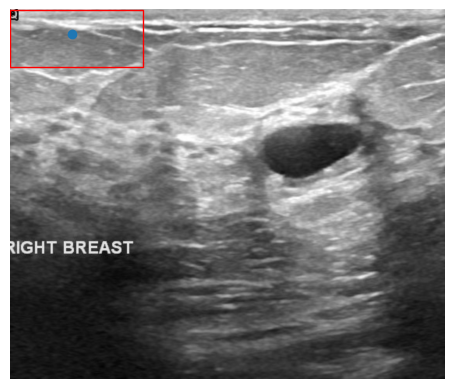

In [16]:
# check if images, boxes and points are transformed correctly
import matplotlib.patches as patches
for batch,item in batch_dataloader(valid_dataframe, 1, 'BBox+Point', shuffle=True, random_state=None):
    item=item[0]

    img = item['image'].cpu()
    boxes = item['boxes']
    point_coords = item['point_coords'].cpu().numpy().squeeze().squeeze()
    point_labels = item['point_labels']

    fig,ax = plt.subplots(1)
    ax.imshow(img.permute(1, 2, 0))
    for box in boxes:
        box = box.cpu().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.scatter(point_coords[0],point_coords[1])
    ax.axis('off')
    plt.show()
    break

In [22]:
def clear_vram():
    if DEVICE == 'cuda':
        torch.cuda.empty_cache()
        gc.collect()
    else:
        pass

In [26]:
# define function to unpack batched output and save the masks
def unpack_and_save_op(indices, batch_op, data_frame,save_dir):
    '''
    indices: list of indices in original data_frame
    batch_op: list of output dictionaries
    data_frame: original data_frame
    save_dir: directory to save the output masks
    '''
    # Check if save_dir exists, create it if it doesn't
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    #make directories for benign and malignant and normal
    if not os.path.exists(os.path.join(save_dir, 'benign')):
        os.makedirs(os.path.join(save_dir, 'benign'))
    if not os.path.exists(os.path.join(save_dir, 'malignant')):
        os.makedirs(os.path.join(save_dir, 'malignant'))
    if not os.path.exists(os.path.join(save_dir, 'normal')):
        os.makedirs(os.path.join(save_dir, 'normal'))
        
    
    for i, index in enumerate(indices):
        # get the row for index
        row = data_frame.iloc[index]

        # get the output dictionary
        op_dict = batch_op[i]

        # get the mask
        mask = op_dict['masks'].squeeze().cpu().numpy()

        # save mask to given directory with name in dafaframe with added prediction word
        #mask_path = os.path.join(save_dir, row['image'].replace('mask.png', 'mask_prediction.png'))
        #print(f'Saving mask at {mask_path}')
        #saave acording to the name if benign in image save in benign folder and if malignant in image save in malignant folder
        if 'benign' in row['image']:
            mask_path = os.path.join(save_dir, 'benign', row['path'].split(os.sep)[-1].replace('.png', '_mask_prediction.png'))
        elif 'malignant' in row['image']:
            mask_path = os.path.join(save_dir, 'malignant', row['path'].split(os.sep)[-1].replace('.png', '_mask_prediction.png'))
        else:#normal
            mask_path = os.path.join(save_dir, 'normal', row['path'].split(os.sep)[-1].replace('.png', '_mask_prediction.png'))
            

        # save the mask
        plt.imsave(mask_path, mask, cmap='gray')

        # clear the memory
        del op_dict
        clear_vram()

In [27]:
# clear vram before starting
clear_vram()

## only BBox prompt

In [28]:
path_to_save = os.path.join('SAM_predictions_BBox','valid')
with tqdm.tqdm(total=len(valid_dataframe)) as pbar:
    for indices, batch in batch_dataloader(valid_dataframe,2,prompt='BBox',shuffle=False):
        with torch.no_grad():
            batch_op = sam_model(batch, multimask_output = False)
            clear_vram()
            unpack_and_save_op(indices, batch_op, valid_dataframe,path_to_save) 
        pbar.update(2)

  0%|          | 0/112 [00:00<?, ?it/s]

 12%|█▎        | 14/112 [00:27<03:13,  1.98s/it]


KeyboardInterrupt: 

In [25]:
#print count of images in each folder
print('Number of images in each folder')
print('Benign:',len(os.listdir(os.path.join('SAM_predictions_BBox','valid','benign'))))
print('Malignant:',len(os.listdir(os.path.join('SAM_predictions_BBox','valid','malignant'))))
print('Normal:',len(os.listdir(os.path.join('SAM_predictions_BBox','valid','normal'))))


Number of images in each folder
Benign: 84
Malignant: 44
Normal: 28


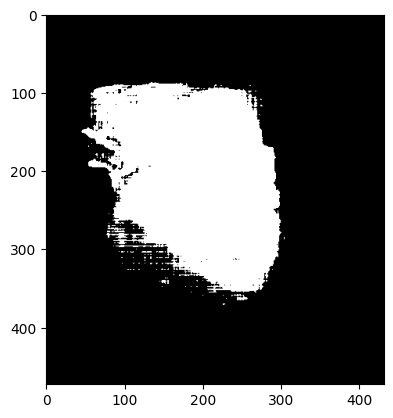

In [26]:
#load the image SAM_predictions_BBox/valid/malignant (4).png

image = cv2.imread('SAM_predictions_BBox/valid/malignant/malignant (4)_mask_prediction.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [27]:
path_to_save = os.path.join('SAM_predictions_BBox','train')
with tqdm.tqdm(total=len(train_dataframe)) as pbar:
    for indices, batch in batch_dataloader(train_dataframe,2,prompt='BBox',shuffle=False):
        with torch.no_grad():
            batch_op = sam_model(batch, multimask_output = False)
            clear_vram()
            unpack_and_save_op(indices, batch_op, train_dataframe, path_to_save)
        pbar.update(2)

100%|██████████| 624/624 [05:45<00:00,  1.81it/s]


In [28]:
#print count of images in each folder
print('Number of images in each folder')
print('Benign:',len(os.listdir(os.path.join('SAM_predictions_BBox','train','benign'))))
print('Malignant:',len(os.listdir(os.path.join('SAM_predictions_BBox','train','malignant'))))
print('Normal:',len(os.listdir(os.path.join('SAM_predictions_BBox','train','normal'))))

Number of images in each folder
Benign: 354
Malignant: 166
Normal: 104


In [29]:
# clear vram 
clear_vram()

## only Point prompt

In [30]:
path_to_save = os.path.join('SAM_predictions_Point','valid')
with tqdm.tqdm(total=len(valid_dataframe)) as pbar:
    for indices, batch in batch_dataloader(valid_dataframe,2,prompt='Point',shuffle=False):
        with torch.no_grad():
            batch_op = sam_model(batch, multimask_output = False)
            clear_vram()
            unpack_and_save_op(indices, batch_op, valid_dataframe,path_to_save) 
        pbar.update(2)

 99%|█████████▉| 156/157 [01:28<00:00,  1.76it/s]


In [31]:
#print count of images in each folder
print('Number of images in each folder')
print('Benign:',len(os.listdir(os.path.join('SAM_predictions_Point','valid','benign'))))
print('Malignant:',len(os.listdir(os.path.join('SAM_predictions_Point','valid','malignant'))))
print('Normal:',len(os.listdir(os.path.join('SAM_predictions_Point','valid','normal'))))

Number of images in each folder
Benign: 84
Malignant: 44
Normal: 28


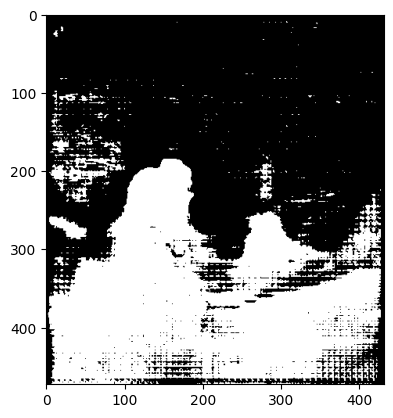

In [32]:
#load the image SAM_predictions_BBox/valid/malignant (4).png

image = cv2.imread('SAM_predictions_Point/valid/malignant/malignant (4)_mask_prediction.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [33]:
path_to_save = os.path.join('SAM_predictions_Point','train')
with tqdm.tqdm(total=len(train_dataframe)) as pbar:
    for indices, batch in batch_dataloader(train_dataframe,2,prompt='Point',shuffle=False):
        with torch.no_grad():
            batch_op = sam_model(batch, multimask_output = False)
            clear_vram()
            unpack_and_save_op(indices, batch_op, train_dataframe, path_to_save)
        pbar.update(2)

100%|██████████| 624/624 [05:59<00:00,  1.74it/s]


In [34]:
# clear vram 
clear_vram()

## BBox+Point prompt

In [35]:
path_to_save = os.path.join('SAM_predictions_BBoxPoint','valid')
with tqdm.tqdm(total=len(valid_dataframe)) as pbar:
    for indices, batch in batch_dataloader(valid_dataframe,2,prompt='BBox+Point',shuffle=False):
        with torch.no_grad():
            batch_op = sam_model(batch, multimask_output = False)
            clear_vram()
            unpack_and_save_op(indices, batch_op, valid_dataframe,path_to_save) 
        pbar.update(2)

 99%|█████████▉| 156/157 [01:28<00:00,  1.76it/s]


In [36]:
path_to_save = os.path.join('SAM_predictions_BBoxPoint','train')
with tqdm.tqdm(total=len(train_dataframe)) as pbar:
    for indices, batch in batch_dataloader(train_dataframe,2,prompt='BBox+Point',shuffle=False):
        with torch.no_grad():
            batch_op = sam_model(batch, multimask_output = False)
            clear_vram()
            unpack_and_save_op(indices, batch_op, train_dataframe, path_to_save)
        pbar.update(2)

100%|██████████| 624/624 [05:55<00:00,  1.76it/s]


In [20]:
# clear vram 
clear_vram()